# Affichage des données téléphoniques

## Imports

In [66]:
import folium
import pandas as pd;
import mapUtils
import IHM
import branca
import copy
import branca
import folium
from selenium import webdriver
from PIL import Image
import io
from selenium.webdriver.chrome.service import Service
from pathlib import Path
from PIL import Image
import os
from pyproj import Transformer
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.cluster import HDBSCAN
import numpy as np



## Plotting and saving subplots of maps

In [3]:
ntechs = len(IHM.technologies)
nprovs = len(IHM.providers)

Fonction pour créer une image à partir d'un fichier html 

In [4]:
def save_png(html_file, png_file, compressing_factor = 1):      
    # Configurer Selenium WebDriver
    service = Service(executable_path=r'/usr/bin/chromedriver')
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    driver = webdriver.Chrome(service=service, options=options)
    driver.set_window_size(2760, 1600)
    # Charger la page HTML dans le navigateur
    driver.get(f"file://{str(Path().absolute())}/{html_file}")

    # Prendre une capture d'écran de l'élément
    screenshot = driver.get_screenshot_as_png()
    driver.quit()

    # Convertir la capture d'écran en image avec Pillow
    image = Image.open(io.BytesIO(screenshot))

    # Compresser l'image
    width, height = image.size
    new_size = (width//compressing_factor, height//compressing_factor)
    image = image.resize(new_size)

    # Enregistrer l'image en PNG
    image.save(png_file)

Traçage des comparaisons des différents opérateurs pour chaque technologie

In [5]:
for technology in IHM.technologies :
    fig = branca.element.Figure()
    for i, provider in enumerate(IHM.providers) :
        subplot = fig.add_subplot(int(nprovs/2), nprovs-int(nprovs/2), i+1)
        subplot.add_child(mapUtils.getMap(copy.deepcopy(IHM.df), [provider], IHM.regions, [technology], "Opérateurs", location = [46.8, 2.3], zoom_start = 6)) 
    mapUtils.addLegend(fig,{'Bouygues Telecom':'#035afc', 'Orange':'#fc5603', 'SFR':'#169e26', 'Free Mobile':'#dbd640'})
    fig.save(f"../../out/maps/providers-{technology}.html")
    save_png(f"../../out/maps/providers-{technology}.html", f"../../out/images/providers-{technology}.png", 2)

Traçage des répartitions des stations de base selon les opérateurs

In [6]:
fig = branca.element.Figure()
for i,provider in enumerate(IHM.providers) :
    subplot = fig.add_subplot(int(nprovs/2), nprovs-int(nprovs/2), i+1)
    subplot.add_child(mapUtils.getMap(copy.deepcopy(IHM.df), [provider], IHM.regions, IHM.technologies, "Opérateurs", location = [46.8, 2.3], zoom_start = 6)) 
mapUtils.addLegend(fig,{'Bouygues Telecom':'#035afc', 'Orange':'#fc5603', 'SFR':'#169e26', 'Free Mobile':'#dbd640'})
fig.save("../../out/maps/subplots-operators.html")
save_png("../../out/maps/subplots-operators.html", "../../out/images/subplots-operators.png", 2)

### Couverture ciblée

In [7]:
data_couv_cible = pd.read_csv("../../database/2023_T4_dcc_Metropole_sites.csv", sep=";", decimal=',')
Nan_values_data_couv_cible = data_couv_cible[data_couv_cible['x_lambert_93'].isnull() | data_couv_cible['y_lambert_93'].isnull()]
data_couv_cible.dropna(axis=0, how='any', subset=['x_lambert_93', 'y_lambert_93'], inplace=True)


In [8]:
Nan_values_data_couv_cible[['x_lambert_93', 'y_lambert_93']]

,x_lambert_93,y_lambert_93
68,NaN,NaN
102,NaN,NaN
113,NaN,NaN
115,NaN,NaN
116,NaN,NaN
...,...,...
4548,NaN,NaN
4552,NaN,NaN
4553,NaN,NaN
4562,NaN,NaN


In [9]:
map = folium.Map(location=[46.8, 2.3], zoom_start=7, tiles="Cartodb Positron")

# Définir le transformateur pour la conversion de Lambert 93 à WGS84
transformer = Transformer.from_crs("epsg:2154", "epsg:4326")

for ind, x, y in data_couv_cible[['x_lambert_93', 'y_lambert_93']].itertuples():
    # Convertir les coordonnées Lambert 93 en longitude/latitude
    latitude, longitude = transformer.transform(x, y)
    map.add_child(folium.RegularPolygonMarker(location=[latitude, longitude], fill_opacity=0.2, radius=1.5, popup=f"({x}, {y})"))
map.save("../../out/maps/couverture_ciblee.html")
save_png("../../out/maps/couverture_ciblee.html","../../out/images/couverture_ciblee.png", 2)

## H-DBScan

In [21]:
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

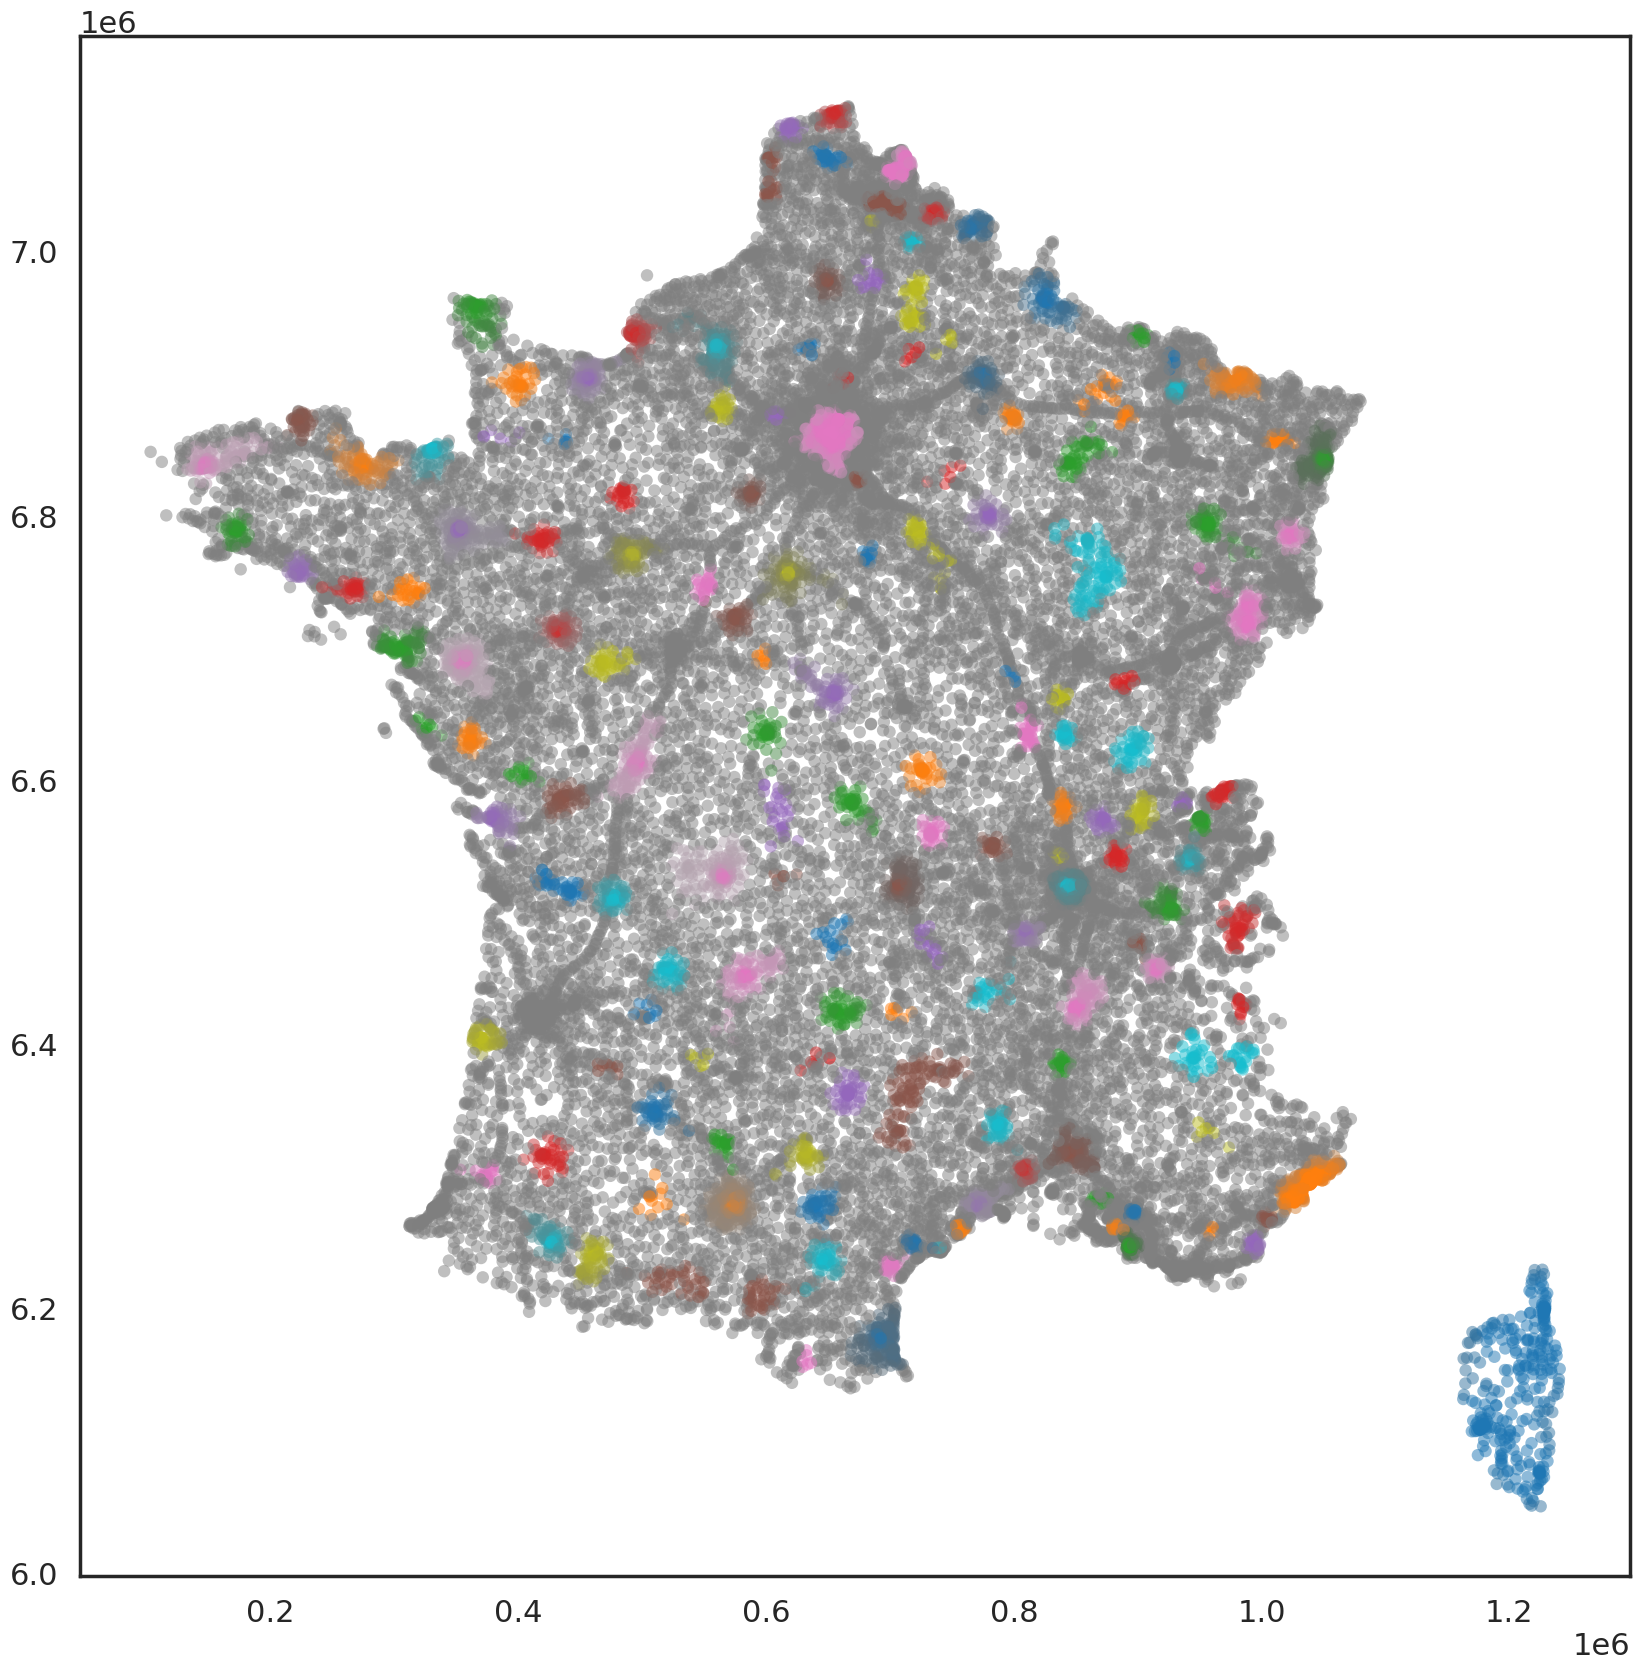

In [52]:
df = pd.read_csv("../../database/data.csv", sep=";", decimal=',')
# df = df.sample(frac=1).reset_index(drop=True)
df_filtered = df[df['nom_op']=='Orange']
data = df_filtered[['x', 'y']]

clusterer= HDBSCAN(min_cluster_size=5, min_samples=30)
clusterer.fit(data)

palette = sns.color_palette(n_colors=len(np.unique(clusterer.labels_)))
cluster_colors = [sns.desaturate(palette[col], sat) if col >= 0 else (0.5, 0.5, 0.5) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
plt.figure(figsize=(20, 20))
plt.scatter(data['x'], data['y'], c=cluster_colors, **plot_kwds)

In [79]:
# Create a colormap
cmap = plt.cm.get_cmap('winter_r')  # 'cool' colormap for blue to gray
norm = mcolors.Normalize(vmin=0, vmax=1)
-1
map = folium.Map(location=[46.8, 2.3], zoom_start=7, tiles="Cartodb Positron")

for ind, (_, x, y) in enumerate(data.itertuples()):
    proba = clusterer.probabilities_[ind]
    color = 'gray' if proba == 0 else mcolors.to_hex(cmap(norm(proba)))
    # Convertir les coordonnées Lambert 93 en longitude/latitude
    latitude, longitude = transformer.transform(x, y)
    map.add_child(folium.RegularPolygonMarker(location=[latitude, longitude], color=, radius=1.5, popup=f"proba={clusterer.probabilities_[ind]}"))
map.save("../../out/maps/villes_HDBSCAN.html")
save_png("../../out/maps/villes_HDBSCAN.html","../../out/images/villes_HDBSCAN.png", 2)